In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

# Configure character display
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# Define column names
cols = ['label'] + [f'I{i}' for i in range(1, 14)] + [f'C{i}' for i in range(1, 27)]

num_features = [f'I{i}' for i in range(1, 14)]  # Numerical features

# Load data (first 10,000 rows)
data = pd.read_csv('../../data/raw/train.txt', sep='\t', header=None, names=cols, nrows=10000)

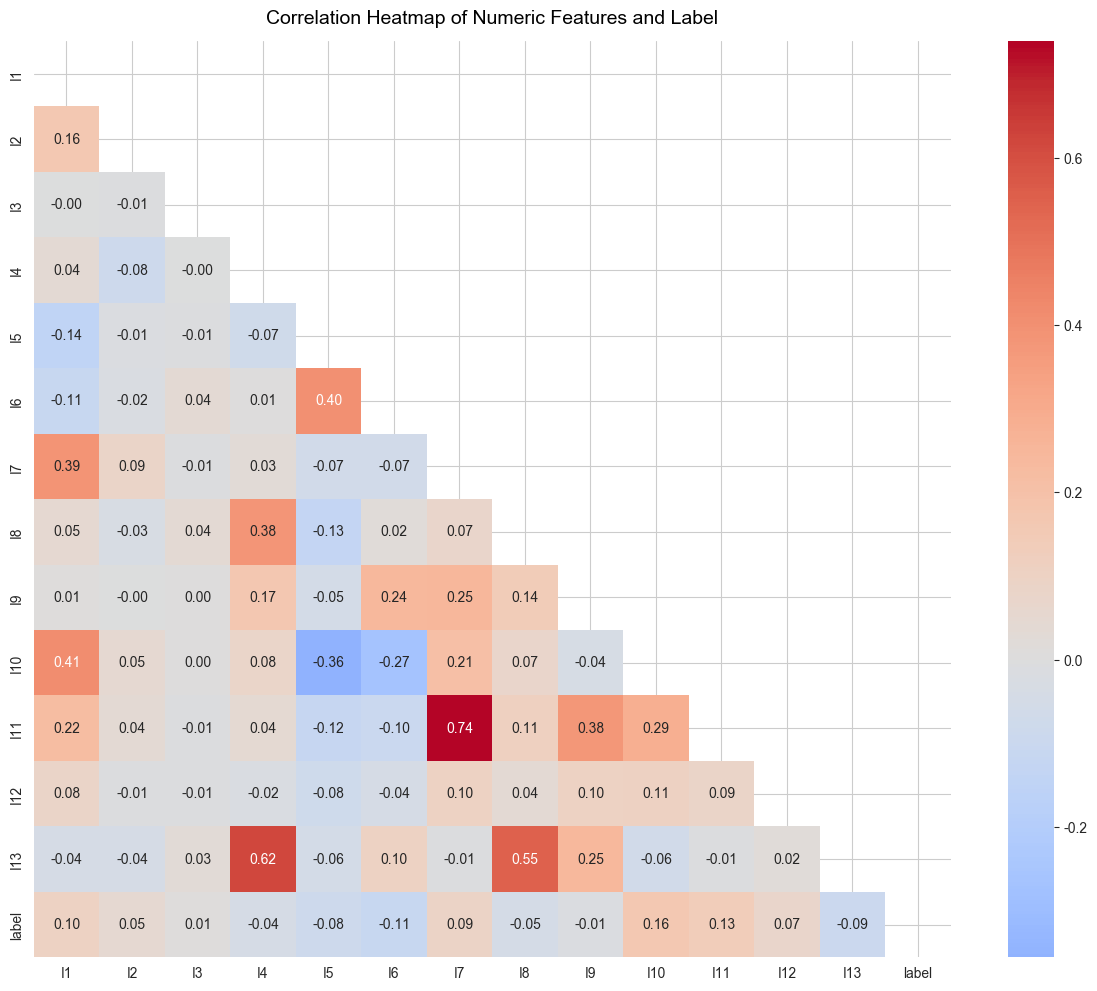

Correlation Heatmap Explanation:
1. Shows correlation coefficients between all numeric features and with the label
2. Presented as a lower triangular matrix to avoid duplicate display
3. Darker colors indicate stronger correlation (red for positive, blue for negative)


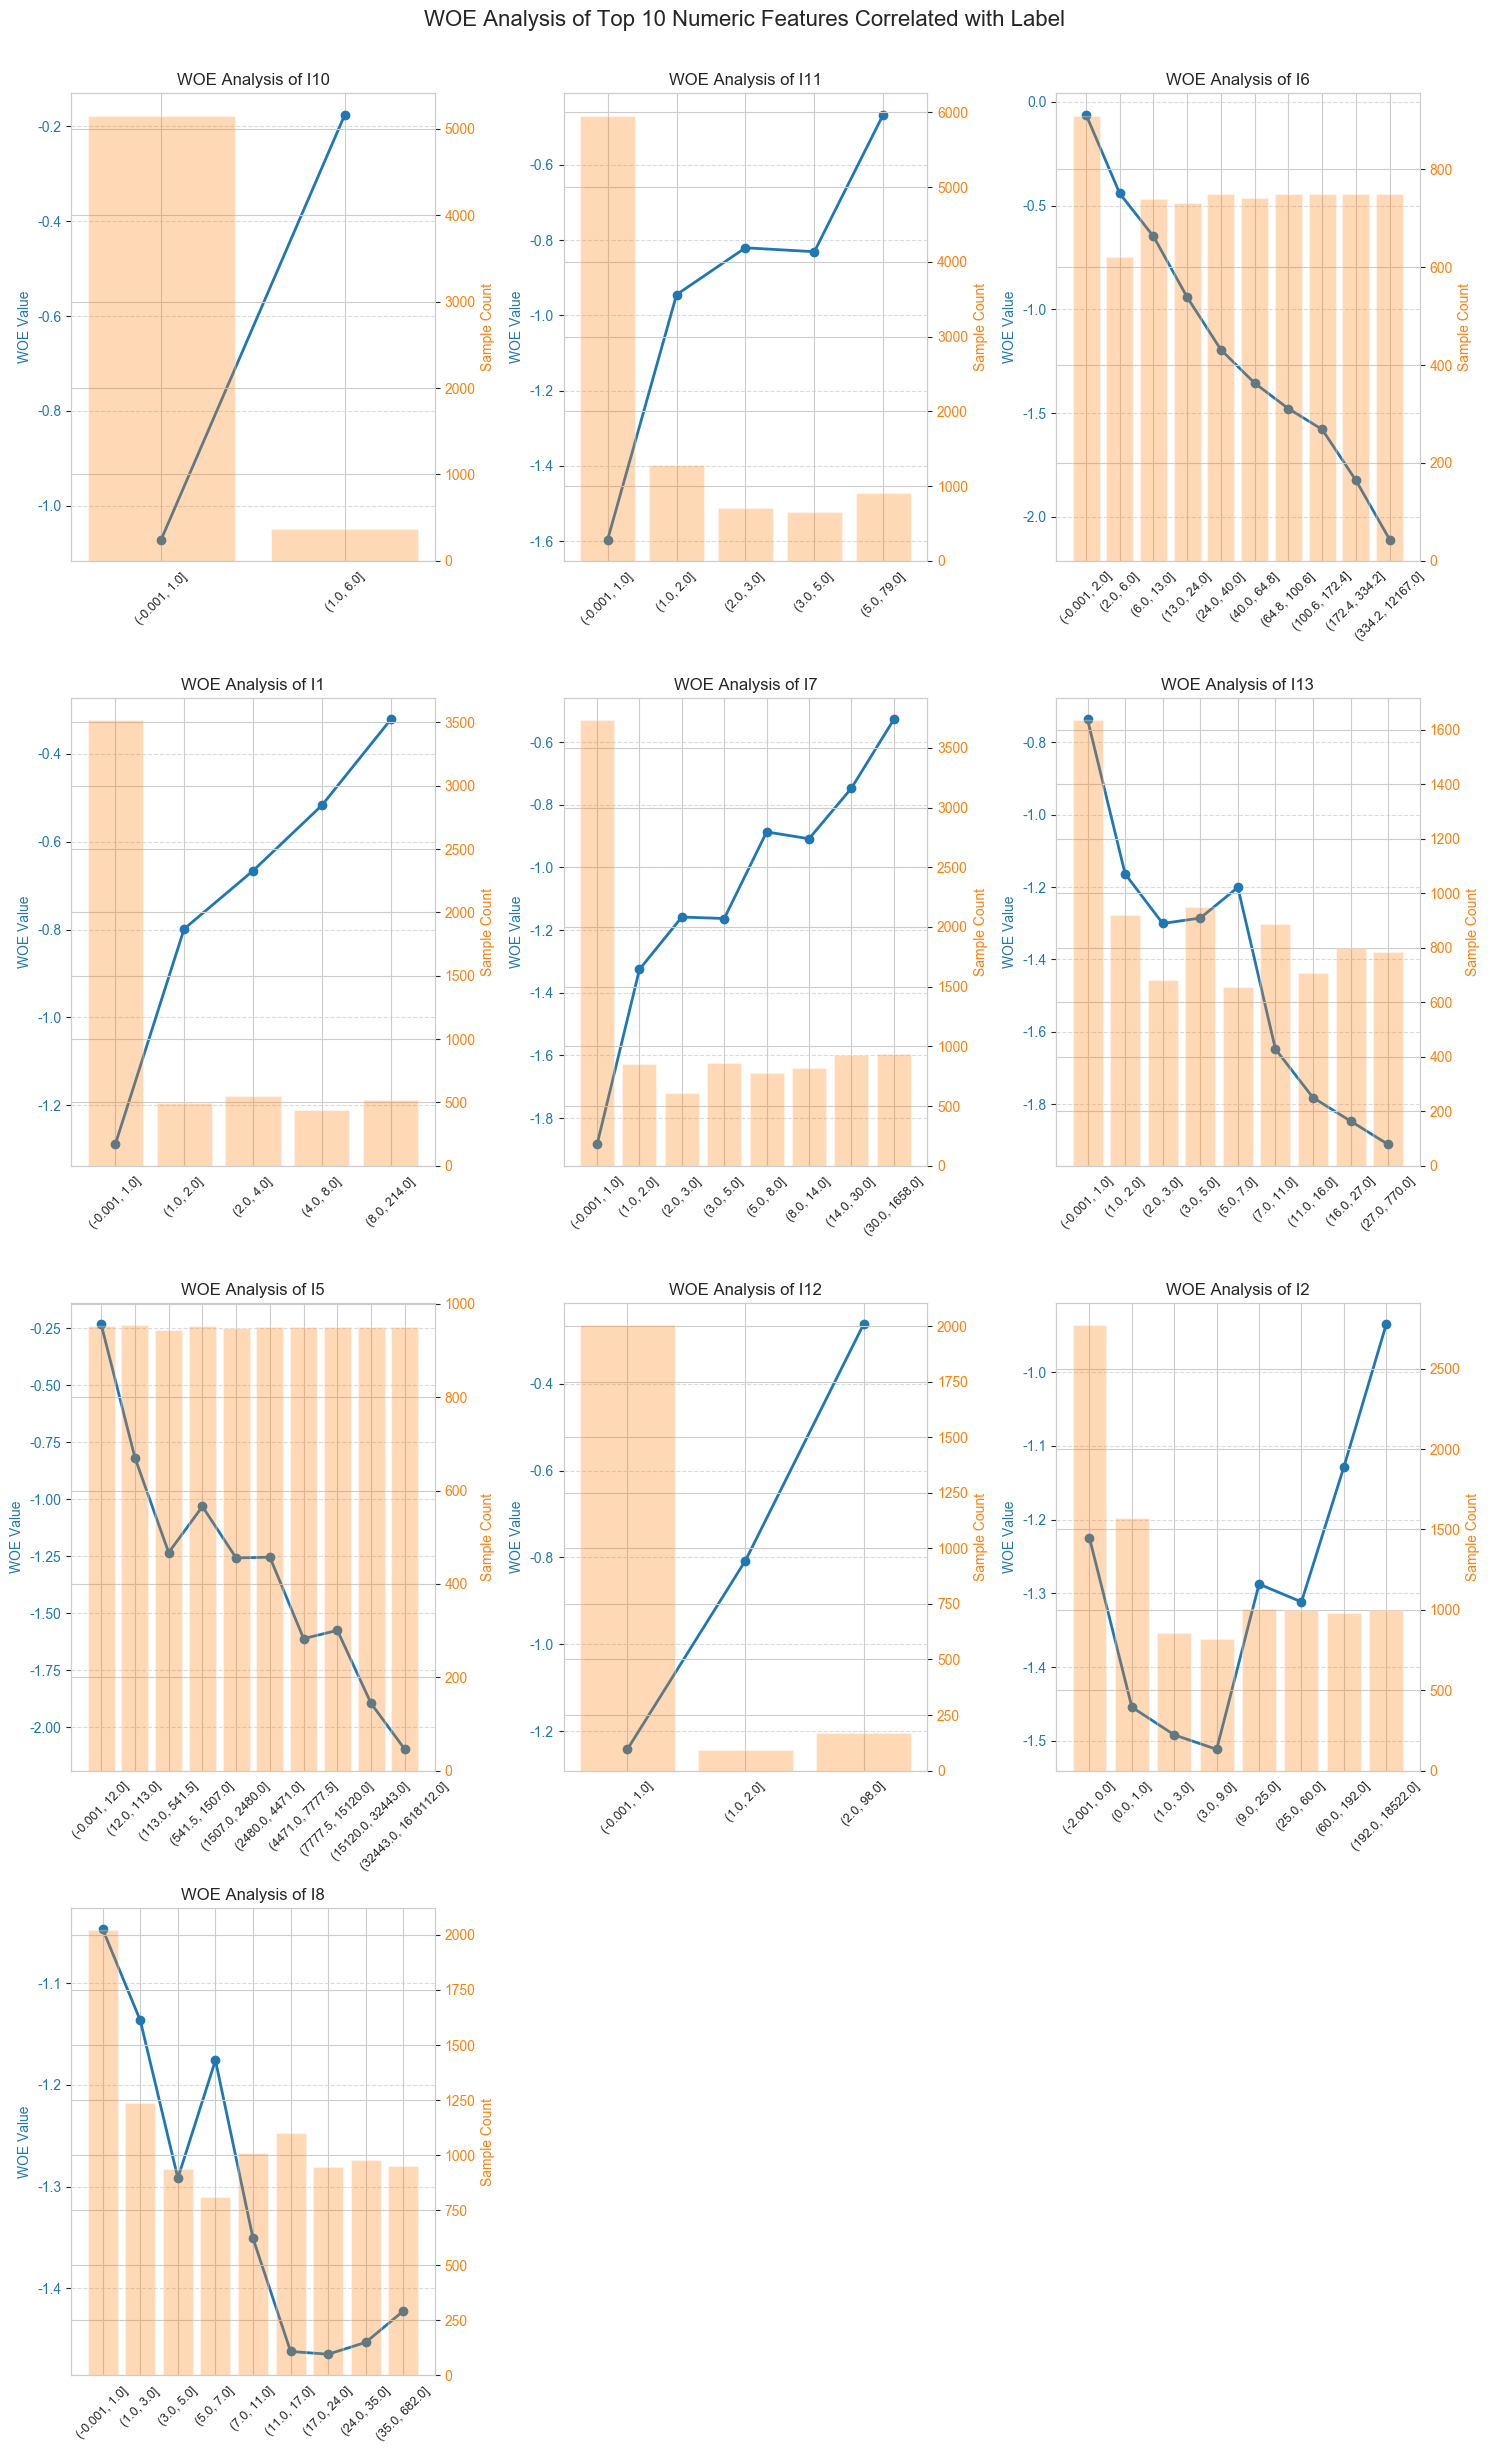

,Feature Name,Original Correlation,Absolute Correlation
0,I10,0.163700,0.163700
1,I11,0.134600,0.134600
2,I6,-0.110000,0.110000
3,I1,0.098400,0.098400
4,I7,0.093100,0.093100
5,I13,-0.093000,0.093000
6,I5,-0.083300,0.083300
7,I12,0.068500,0.068500
8,I2,0.048500,0.048500
9,I8,-0.046200,0.046200


In [6]:
# Numeric Feature Correlation with Label and WOE Analysis
# ====================
# 1. Calculate correlation between numeric features and label, plot heatmap
# ====================

# Calculate correlation matrix (Pearson correlation)
corr_matrix = data[num_features + ['label']].corr(method='pearson')

# Visualize heatmap (lower triangular matrix)
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(
    corr_matrix,
    annot=True,  # Display correlation coefficient values
    fmt=".2f",  # Keep two decimal places
    cmap='coolwarm',  # Use cool-warm color palette
    center=0,  # Center color scale at 0
    mask=np.triu(np.ones_like(corr_matrix))  # Hide upper triangle
)
plt.title('Correlation Heatmap of Numeric Features and Label', fontsize=14, fontweight='bold', color='black', y=1.01)
plt.tight_layout()
plt.show()

# Supplementary explanation: Correlation heatmap
print("Correlation Heatmap Explanation:")
print("1. Shows correlation coefficients between all numeric features and with the label")
print("2. Presented as a lower triangular matrix to avoid duplicate display")
print("3. Darker colors indicate stronger correlation (red for positive, blue for negative)")


# ====================
# 2. Define WOE analysis function
# ====================
def plot_woe_analysis(feature, target='label', bins=10, ax1=None, ax2=None):
    """
    Plot WOE analysis chart for a feature
    - Left axis: WOE values (line chart)
    - Right axis: Sample count per bin (bar chart)
    """
    df = data[[feature, target]].copy()

    # Handle binning to ensure no empty bins
    try:
        # Prefer equal-frequency binning
        df['bins'] = pd.qcut(df[feature], q=bins, duplicates='drop')
    except ValueError:
        # Use equal-width binning if equal-frequency fails
        df['bins'] = pd.cut(df[feature], bins=bins)
    except Exception as e:
        # Use fewer bins for other binning errors
        df['bins'] = pd.cut(df[feature], bins=5)
        print(f"Error binning {feature}, automatically adjusted to 5 bins: {str(e)}")

    # Calculate bad rate and sample count for each bin
    woe_df = df.groupby('bins', observed=True)[target].agg(['mean', 'count'])

    # Avoid division by zero, limit bad rate range
    woe_df['mean'] = woe_df['mean'].clip(lower=1e-10, upper=1 - 1e-10)
    # Calculate WOE values (WOE = ln(bad rate/good rate))
    woe_df['woe'] = np.log(woe_df['mean'] / (1 - woe_df['mean']))

    # Handle axes
    if ax1 is None and ax2 is None:
        fig, ax1 = plt.subplots(figsize=(10, 6))
        ax2 = ax1.twinx()
    elif ax2 is None:
        ax2 = ax1.twinx()

    # Left axis: Plot WOE line chart
    ax1.plot(
        woe_df.index.astype(str),
        woe_df['woe'],
        color='tab:blue',
        marker='o',
        linewidth=2,
        markersize=6
    )
    ax1.set_ylabel('WOE Value', color='tab:blue', fontsize=10)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_title(f'WOE Analysis of {feature}', fontsize=12)
    ax1.tick_params(axis='x', rotation=45, labelsize=9)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Right axis: Plot sample count bar chart
    ax2.bar(
        woe_df.index.astype(str),
        woe_df['count'],
        alpha=0.3,
        color='tab:orange'
    )
    ax2.set_ylabel('Sample Count', color='tab:orange', fontsize=10)
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    return ax1, ax2


# ====================
# 3. Perform WOE analysis on top N correlated features (3 subplots per row)
# ====================
# Get top 10 features with highest correlation to label (sorted by absolute value)
top_n = 10  # Adjustable number of features to analyze
top_num_features = corr_matrix['label'].abs().sort_values(ascending=False).index[1:top_n + 1]
n_features = len(top_num_features)

# Calculate layout: 3 subplots per row
cols_per_row = 3
rows_needed = (n_features + cols_per_row - 1) // cols_per_row  # Round up

# Create subplot grid
fig, axes = plt.subplots(rows_needed, cols_per_row, figsize=(5 * cols_per_row, 6 * rows_needed))
axes = axes.flatten()  # Convert to 1D array for easy iteration

# Plot WOE analysis for each feature
for i, feature in enumerate(top_num_features):
    ax1 = axes[i]
    ax2 = ax1.twinx()  # Create dual axis
    plot_woe_analysis(feature, ax1=ax1, ax2=ax2)

# Hide unused subplots
for j in range(n_features, rows_needed * cols_per_row):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.suptitle(f'WOE Analysis of Top {top_n} Numeric Features Correlated with Label', fontsize=16, y=1.02)

plt.show()

# ====================
# 4. Output correlation ranking table
# ====================
corr_rank = corr_matrix['label'].abs().sort_values(ascending=False)[1:].reset_index()
corr_rank.columns = ['Feature Name', 'Absolute Correlation']
corr_rank['Original Correlation'] = corr_matrix.loc[corr_rank['Feature Name'], 'label'].values
corr_rank = corr_rank[['Feature Name', 'Original Correlation', 'Absolute Correlation']].round(4)
display(corr_rank.style.set_caption(f'Numeric Features Correlation Ranking with Label (Top {len(corr_rank)})'))
